In [187]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [188]:
L = 3 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=2
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [189]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [190]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [191]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [192]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [193]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [194]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [195]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [196]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [197]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [198]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [199]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-0.64551385  0.42748942  0.7       ]


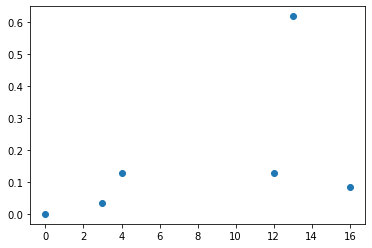

In [200]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [201]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [229]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [230]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [231]:
def R(i,theta):
    
    if i%11 == 0:
        return(ms_gate_global(theta))
    
    if i%11 == 1:
        return(ms_gate_global_1(theta))
    

    if i%11 == 2:
        return(rot_sigma_e(0,1,0,theta).toarray())


    if i%11 == 3:
        return(rot_sigma_e(0,2,0,theta).toarray())

    
    if i%11 == 4:
        return(rot_sigma_e(1,2,np.pi/2,theta).toarray())
    
    
    if i%11 == 5:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%11 == 6:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%11 == 7:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%11 == 8:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%11 == 9:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%11 == 10:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
    
def S(i):
    
    if i%11 == 0:
        return(-1j*matrix_part)
    

    if i%11 == 1:
        return(-1j*matrix_part_1)
    

    if i%11 == 2:
        return(-1j*sigma_e(0,1,0).toarray())

    
    if i%11 == 3:
        return(-1j*sigma_e(0,2,0).toarray())

    
    if i%11 == 4:
        return(-1j*sigma_e(1,2,np.pi/2).toarray())


     
    if i%11 == 5:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%11 == 6:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%11 == 7:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%11 == 8:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%11 == 9:
        return(-1j*sigma_r(0,2,0).toarray())

    
    if i%11 == 10:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())


In [232]:
coeff = 11

In [233]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)
    A = []
    B = []
    for k in range(coeff*N):
        A.append(S(k)@R(k,theta[k]))
        B.append(R(k,theta[k]))
        
    CC = np.einsum("i,ljk->iljk",np.ones(coeff*N),B)
    AA = np.einsum("ijk,il->iljk",A,ID)
    BB = np.einsum("ijk,il->iljk",B,ID)
    DD = CC-BB+AA
    dd = []
    for i in range(coeff*N):
        dd.append(reduce(np.dot,DD[i]))
    DD = np.array(dd)

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)
    
    BBB = reduce(np.dot,B)

    DD_d = np.einsum("kij->kji",DD.conj())
    X = np.einsum("m,imn,jnl,l->ij",np.conj(psi_0),DD_d,DD,psi_0)
    Y = np.einsum("m,imn,nl,lk,k->i",np.conj(psi_0),DD_d,full_ham_matrix.toarray(),BBB,psi_0)
    XX = np.einsum("m,imn,nk,k->i",np.conj(psi_0),DD_d,BBB,psi_0)
    YY_1 = np.einsum("m,mn,ink,k->i",np.conj(psi_0),BBB.conj().T,DD,psi_0)
    YY_2 = np.einsum("m,mn,nk,kl,l",np.conj(psi_0),BBB.conj().T,full_ham_matrix.toarray(),BBB,psi_0 )
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    #v = 1e-6*np.exp(-0)*np.ones(coeff*N)
    #v = np.zeros(coeff*N)
    #X = X + np.diag(v)
    print(t)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)

    return -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i

In [234]:
stepp = 1000

In [235]:
time_domain = np.linspace(0, 10, stepp)


In [236]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [237]:
#start_point = 0.001*np.ones(coeff*N)
expt_value = []
energyy = []

for kkk in range(5):
    Y = []
    start_point = np.random.rand(coeff*N)
    rk4(0,start_point,10,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])

        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

0
0.005
0.005
0.01
0.01
0.015
0.015
0.02
0.02
0.025
0.025
0.03
0.03
0.034999999999999996
0.034999999999999996
0.04
0.04
0.045
0.045
0.05
0.05
0.055
0.055
0.060000000000000005
0.060000000000000005
0.065
0.065
0.07
0.07
0.07500000000000001
0.07500000000000001
0.08
0.08
0.085
0.085
0.09
0.09
0.095
0.095
0.09999999999999999
0.09999999999999999
0.105
0.105
0.10999999999999999
0.10999999999999999
0.11499999999999999
0.11499999999999999
0.11999999999999998
0.11999999999999998
0.12499999999999999
0.12499999999999999
0.12999999999999998
0.12999999999999998
0.13499999999999998
0.13499999999999998
0.13999999999999999
0.13999999999999999
0.145
0.145
0.15
0.15
0.155
0.155
0.16
0.16
0.165
0.165
0.17
0.17
0.17500000000000002
0.17500000000000002
0.18000000000000002
0.18000000000000002
0.18500000000000003
0.18500000000000003
0.19000000000000003
0.19000000000000003
0.19500000000000003
0.19500000000000003
0.20000000000000004
0.20000000000000004
0.20500000000000004
0.20500000000000004
0.21000000000000005


1.1500000000000008
1.1550000000000007
1.1550000000000007
1.1600000000000008
1.1600000000000008
1.1650000000000007
1.1650000000000007
1.1700000000000008
1.1700000000000008
1.1750000000000007
1.1750000000000007
1.1800000000000008
1.1800000000000008
1.1850000000000007
1.1850000000000007
1.1900000000000008
1.1900000000000008
1.1950000000000007
1.1950000000000007
1.2000000000000008
1.2000000000000008
1.2050000000000007
1.2050000000000007
1.2100000000000009
1.2100000000000009
1.2150000000000007
1.2150000000000007
1.2200000000000009
1.2200000000000009
1.2250000000000008
1.2250000000000008
1.2300000000000009
1.2300000000000009
1.2350000000000008
1.2350000000000008
1.2400000000000009
1.2400000000000009
1.2450000000000008
1.2450000000000008
1.2500000000000009
1.2500000000000009
1.2550000000000008
1.2550000000000008
1.260000000000001
1.260000000000001
1.2650000000000008
1.2650000000000008
1.270000000000001
1.270000000000001
1.2750000000000008
1.2750000000000008
1.280000000000001
1.280000000000001

2.2649999999999957
2.2649999999999957
2.2699999999999956
2.2699999999999956
2.2749999999999955
2.2749999999999955
2.2799999999999954
2.2799999999999954
2.2849999999999953
2.2849999999999953
2.289999999999995
2.289999999999995
2.294999999999995
2.294999999999995
2.299999999999995
2.299999999999995
2.304999999999995
2.304999999999995
2.3099999999999947
2.3099999999999947
2.3149999999999946
2.3149999999999946
2.3199999999999945
2.3199999999999945
2.3249999999999944
2.3249999999999944
2.3299999999999943
2.3299999999999943
2.334999999999994
2.334999999999994
2.339999999999994
2.339999999999994
2.344999999999994
2.344999999999994
2.349999999999994
2.349999999999994
2.3549999999999938
2.3549999999999938
2.3599999999999937
2.3599999999999937
2.3649999999999936
2.3649999999999936
2.3699999999999934
2.3699999999999934
2.3749999999999933
2.3749999999999933
2.3799999999999932
2.3799999999999932
2.384999999999993
2.384999999999993
2.389999999999993
2.389999999999993
2.394999999999993
2.394999999999

3.369999999999972
3.374999999999972
3.374999999999972
3.379999999999972
3.379999999999972
3.384999999999972
3.384999999999972
3.3899999999999717
3.3899999999999717
3.3949999999999716
3.3949999999999716
3.3999999999999715
3.3999999999999715
3.4049999999999714
3.4049999999999714
3.4099999999999713
3.4099999999999713
3.414999999999971
3.414999999999971
3.419999999999971
3.419999999999971
3.424999999999971
3.424999999999971
3.429999999999971
3.429999999999971
3.4349999999999707
3.4349999999999707
3.4399999999999706
3.4399999999999706
3.4449999999999705
3.4449999999999705
3.4499999999999704
3.4499999999999704
3.4549999999999703
3.4549999999999703
3.45999999999997
3.45999999999997
3.46499999999997
3.46499999999997
3.46999999999997
3.46999999999997
3.47499999999997
3.47499999999997
3.47999999999997
3.47999999999997
3.4849999999999697
3.4849999999999697
3.4899999999999696
3.4899999999999696
3.4949999999999695
3.4949999999999695
3.4999999999999694
3.4999999999999694
3.5049999999999693
3.5049999

4.494999999999949
4.494999999999949
4.4999999999999485
4.4999999999999485
4.504999999999948
4.504999999999948
4.509999999999948
4.509999999999948
4.514999999999948
4.514999999999948
4.519999999999948
4.519999999999948
4.524999999999948
4.524999999999948
4.529999999999948
4.529999999999948
4.534999999999948
4.534999999999948
4.539999999999948
4.539999999999948
4.5449999999999475
4.5449999999999475
4.549999999999947
4.549999999999947
4.554999999999947
4.554999999999947
4.559999999999947
4.559999999999947
4.564999999999947
4.564999999999947
4.569999999999947
4.569999999999947
4.574999999999947
4.574999999999947
4.579999999999947
4.579999999999947
4.584999999999947
4.584999999999947
4.589999999999947
4.589999999999947
4.5949999999999465
4.5949999999999465
4.599999999999946
4.599999999999946
4.604999999999946
4.604999999999946
4.609999999999946
4.609999999999946
4.614999999999946
4.614999999999946
4.619999999999946
4.619999999999946
4.624999999999946
4.624999999999946
4.629999999999946
4.62

5.629999999999924
5.634999999999924
5.634999999999924
5.639999999999924
5.639999999999924
5.644999999999924
5.644999999999924
5.649999999999924
5.649999999999924
5.654999999999924
5.654999999999924
5.659999999999924
5.659999999999924
5.664999999999924
5.664999999999924
5.6699999999999235
5.6699999999999235
5.674999999999923
5.674999999999923
5.679999999999923
5.679999999999923
5.684999999999923
5.684999999999923
5.689999999999923
5.689999999999923
5.694999999999923
5.694999999999923
5.699999999999923
5.699999999999923
5.704999999999923
5.704999999999923
5.709999999999923
5.709999999999923
5.714999999999923
5.714999999999923
5.7199999999999225
5.7199999999999225
5.724999999999922
5.724999999999922
5.729999999999922
5.729999999999922
5.734999999999922
5.734999999999922
5.739999999999922
5.739999999999922
5.744999999999922
5.744999999999922
5.749999999999922
5.749999999999922
5.754999999999922
5.754999999999922
5.759999999999922
5.759999999999922
5.7649999999999215
5.7649999999999215
5.76

6.7699999999999
6.7699999999999
6.7749999999999
6.7749999999999
6.7799999999999
6.7799999999999
6.7849999999999
6.7849999999999
6.7899999999999
6.7899999999999
6.7949999999999
6.7949999999999
6.7999999999998995
6.7999999999998995
6.804999999999899
6.804999999999899
6.809999999999899
6.809999999999899
6.814999999999899
6.814999999999899
6.819999999999899
6.819999999999899
6.824999999999899
6.824999999999899
6.829999999999899
6.829999999999899
6.834999999999899
6.834999999999899
6.839999999999899
6.839999999999899
6.8449999999998985
6.8449999999998985
6.849999999999898
6.849999999999898
6.854999999999898
6.854999999999898
6.859999999999898
6.859999999999898
6.864999999999898
6.864999999999898
6.869999999999898
6.869999999999898
6.874999999999898
6.874999999999898
6.879999999999898
6.879999999999898
6.884999999999898
6.884999999999898
6.8899999999998975
6.8899999999998975
6.894999999999897
6.894999999999897
6.899999999999897
6.899999999999897
6.904999999999897
6.904999999999897
6.90999999

7.909999999999876
7.909999999999876
7.914999999999876
7.914999999999876
7.919999999999876
7.919999999999876
7.9249999999998755
7.9249999999998755
7.929999999999875
7.929999999999875
7.934999999999875
7.934999999999875
7.939999999999875
7.939999999999875
7.944999999999875
7.944999999999875
7.949999999999875
7.949999999999875
7.954999999999875
7.954999999999875
7.959999999999875
7.959999999999875
7.964999999999875
7.964999999999875
7.9699999999998745
7.9699999999998745
7.974999999999874
7.974999999999874
7.979999999999874
7.979999999999874
7.984999999999874
7.984999999999874
7.989999999999874
7.989999999999874
7.994999999999874
7.994999999999874
7.999999999999874
7.999999999999874
8.004999999999875
8.004999999999875
8.009999999999874
8.009999999999874
8.014999999999874
8.014999999999874
8.019999999999873
8.019999999999873
8.024999999999874
8.024999999999874
8.029999999999873
8.029999999999873
8.034999999999874
8.034999999999874
8.039999999999873
8.039999999999873
8.044999999999874
8.0449

9.054999999999852
9.059999999999851
9.059999999999851
9.064999999999852
9.064999999999852
9.069999999999851
9.069999999999851
9.074999999999852
9.074999999999852
9.07999999999985
9.07999999999985
9.084999999999852
9.084999999999852
9.08999999999985
9.08999999999985
9.094999999999851
9.094999999999851
9.09999999999985
9.09999999999985
9.104999999999851
9.104999999999851
9.10999999999985
9.10999999999985
9.114999999999851
9.114999999999851
9.11999999999985
9.11999999999985
9.12499999999985
9.12499999999985
9.12999999999985
9.12999999999985
9.13499999999985
9.13499999999985
9.13999999999985
9.13999999999985
9.14499999999985
9.14499999999985
9.14999999999985
9.14999999999985
9.15499999999985
9.15499999999985
9.15999999999985
9.15999999999985
9.16499999999985
9.16499999999985
9.169999999999849
9.169999999999849
9.17499999999985
9.17499999999985
9.179999999999849
9.179999999999849
9.18499999999985
9.18499999999985
9.189999999999849
9.189999999999849
9.19499999999985
9.19499999999985
9.199999

0.2700000000000001
0.2700000000000001
0.2750000000000001
0.2750000000000001
0.2800000000000001
0.2800000000000001
0.2850000000000001
0.2850000000000001
0.2900000000000001
0.2900000000000001
0.2950000000000001
0.2950000000000001
0.3000000000000001
0.3000000000000001
0.3050000000000001
0.3050000000000001
0.3100000000000001
0.3100000000000001
0.3150000000000001
0.3150000000000001
0.3200000000000001
0.3200000000000001
0.3250000000000001
0.3250000000000001
0.3300000000000001
0.3300000000000001
0.33500000000000013
0.33500000000000013
0.34000000000000014
0.34000000000000014
0.34500000000000014
0.34500000000000014
0.35000000000000014
0.35000000000000014
0.35500000000000015
0.35500000000000015
0.36000000000000015
0.36000000000000015
0.36500000000000016
0.36500000000000016
0.37000000000000016
0.37000000000000016
0.37500000000000017
0.37500000000000017
0.38000000000000017
0.38000000000000017
0.3850000000000002
0.3850000000000002
0.3900000000000002
0.3900000000000002
0.3950000000000002
0.395000000

1.3450000000000009
1.350000000000001
1.350000000000001
1.3550000000000009
1.3550000000000009
1.360000000000001
1.360000000000001
1.3650000000000009
1.3650000000000009
1.370000000000001
1.370000000000001
1.3750000000000009
1.3750000000000009
1.380000000000001
1.380000000000001
1.385000000000001
1.385000000000001
1.390000000000001
1.390000000000001
1.395000000000001
1.395000000000001
1.400000000000001
1.400000000000001
1.405000000000001
1.405000000000001
1.410000000000001
1.410000000000001
1.415000000000001
1.415000000000001
1.420000000000001
1.420000000000001
1.425000000000001
1.425000000000001
1.430000000000001
1.430000000000001
1.435000000000001
1.435000000000001
1.440000000000001
1.440000000000001
1.445000000000001
1.445000000000001
1.450000000000001
1.450000000000001
1.455000000000001
1.455000000000001
1.460000000000001
1.460000000000001
1.465000000000001
1.465000000000001
1.470000000000001
1.470000000000001
1.475000000000001
1.475000000000001
1.480000000000001
1.480000000000001
1.4

2.4599999999999915
2.4649999999999914
2.4649999999999914
2.4699999999999913
2.4699999999999913
2.474999999999991
2.474999999999991
2.479999999999991
2.479999999999991
2.484999999999991
2.484999999999991
2.489999999999991
2.489999999999991
2.494999999999991
2.494999999999991
2.4999999999999907
2.4999999999999907
2.5049999999999906
2.5049999999999906
2.5099999999999905
2.5099999999999905
2.5149999999999904
2.5149999999999904
2.5199999999999902
2.5199999999999902
2.52499999999999
2.52499999999999
2.52999999999999
2.52999999999999
2.53499999999999
2.53499999999999
2.53999999999999
2.53999999999999
2.5449999999999897
2.5449999999999897
2.5499999999999896
2.5499999999999896
2.5549999999999895
2.5549999999999895
2.5599999999999894
2.5599999999999894
2.5649999999999893
2.5649999999999893
2.569999999999989
2.569999999999989
2.574999999999989
2.574999999999989
2.579999999999989
2.579999999999989
2.584999999999989
2.584999999999989
2.5899999999999888
2.5899999999999888
2.5949999999999886
2.594999

3.569999999999968
3.569999999999968
3.5749999999999678
3.5749999999999678
3.5799999999999677
3.5799999999999677
3.5849999999999675
3.5849999999999675
3.5899999999999674
3.5899999999999674
3.5949999999999673
3.5949999999999673
3.5999999999999672
3.5999999999999672
3.604999999999967
3.604999999999967
3.609999999999967
3.609999999999967
3.614999999999967
3.614999999999967
3.619999999999967
3.619999999999967
3.6249999999999667
3.6249999999999667
3.6299999999999666
3.6299999999999666
3.6349999999999665
3.6349999999999665
3.6399999999999664
3.6399999999999664
3.6449999999999663
3.6449999999999663
3.649999999999966
3.649999999999966
3.654999999999966
3.654999999999966
3.659999999999966
3.659999999999966
3.664999999999966
3.664999999999966
3.6699999999999657
3.6699999999999657
3.6749999999999656
3.6749999999999656
3.6799999999999655
3.6799999999999655
3.6849999999999654
3.6849999999999654
3.6899999999999653
3.6899999999999653
3.694999999999965
3.694999999999965
3.699999999999965
3.699999999999

4.694999999999944
4.694999999999944
4.699999999999944
4.699999999999944
4.704999999999944
4.704999999999944
4.709999999999944
4.709999999999944
4.714999999999944
4.714999999999944
4.719999999999944
4.719999999999944
4.724999999999944
4.724999999999944
4.729999999999944
4.729999999999944
4.7349999999999435
4.7349999999999435
4.739999999999943
4.739999999999943
4.744999999999943
4.744999999999943
4.749999999999943
4.749999999999943
4.754999999999943
4.754999999999943
4.759999999999943
4.759999999999943
4.764999999999943
4.764999999999943
4.769999999999943
4.769999999999943
4.774999999999943
4.774999999999943
4.7799999999999425
4.7799999999999425
4.784999999999942
4.784999999999942
4.789999999999942
4.789999999999942
4.794999999999942
4.794999999999942
4.799999999999942
4.799999999999942
4.804999999999942
4.804999999999942
4.809999999999942
4.809999999999942
4.814999999999942
4.814999999999942
4.819999999999942
4.819999999999942
4.824999999999942
4.824999999999942
4.8299999999999415
4.829

5.82999999999992
5.83499999999992
5.83499999999992
5.83999999999992
5.83999999999992
5.84499999999992
5.84499999999992
5.84999999999992
5.84999999999992
5.85499999999992
5.85499999999992
5.8599999999999195
5.8599999999999195
5.864999999999919
5.864999999999919
5.869999999999919
5.869999999999919
5.874999999999919
5.874999999999919
5.879999999999919
5.879999999999919
5.884999999999919
5.884999999999919
5.889999999999919
5.889999999999919
5.894999999999919
5.894999999999919
5.899999999999919
5.899999999999919
5.9049999999999185
5.9049999999999185
5.909999999999918
5.909999999999918
5.914999999999918
5.914999999999918
5.919999999999918
5.919999999999918
5.924999999999918
5.924999999999918
5.929999999999918
5.929999999999918
5.934999999999918
5.934999999999918
5.939999999999918
5.939999999999918
5.944999999999918
5.944999999999918
5.949999999999918
5.949999999999918
5.9549999999999175
5.9549999999999175
5.959999999999917
5.959999999999917
5.964999999999917
5.964999999999917
5.9699999999999

6.969999999999896
6.974999999999896
6.974999999999896
6.979999999999896
6.979999999999896
6.9849999999998955
6.9849999999998955
6.989999999999895
6.989999999999895
6.994999999999895
6.994999999999895
6.999999999999895
6.999999999999895
7.004999999999895
7.004999999999895
7.009999999999895
7.009999999999895
7.014999999999895
7.014999999999895
7.019999999999895
7.019999999999895
7.024999999999895
7.024999999999895
7.0299999999998946
7.0299999999998946
7.0349999999998944
7.0349999999998944
7.039999999999894
7.039999999999894
7.044999999999894
7.044999999999894
7.049999999999894
7.049999999999894
7.054999999999894
7.054999999999894
7.059999999999894
7.059999999999894
7.064999999999894
7.064999999999894
7.069999999999894
7.069999999999894
7.074999999999894
7.074999999999894
7.0799999999998935
7.0799999999998935
7.084999999999893
7.084999999999893
7.089999999999893
7.089999999999893
7.094999999999893
7.094999999999893
7.099999999999893
7.099999999999893
7.104999999999893
7.104999999999893
7.

8.109999999999872
8.109999999999872
8.114999999999872
8.114999999999872
8.119999999999871
8.119999999999871
8.124999999999872
8.124999999999872
8.129999999999871
8.129999999999871
8.134999999999872
8.134999999999872
8.139999999999871
8.139999999999871
8.144999999999872
8.144999999999872
8.14999999999987
8.14999999999987
8.154999999999871
8.154999999999871
8.15999999999987
8.15999999999987
8.164999999999871
8.164999999999871
8.16999999999987
8.16999999999987
8.174999999999871
8.174999999999871
8.17999999999987
8.17999999999987
8.18499999999987
8.18499999999987
8.18999999999987
8.18999999999987
8.19499999999987
8.19499999999987
8.19999999999987
8.19999999999987
8.20499999999987
8.20499999999987
8.20999999999987
8.20999999999987
8.21499999999987
8.21499999999987
8.21999999999987
8.21999999999987
8.22499999999987
8.22499999999987
8.229999999999869
8.229999999999869
8.23499999999987
8.23499999999987
8.239999999999869
8.239999999999869
8.24499999999987
8.24499999999987
8.249999999999869
8.24

9.259999999999847
9.264999999999848
9.264999999999848
9.269999999999847
9.269999999999847
9.274999999999848
9.274999999999848
9.279999999999847
9.279999999999847
9.284999999999847
9.284999999999847
9.289999999999846
9.289999999999846
9.294999999999847
9.294999999999847
9.299999999999846
9.299999999999846
9.304999999999847
9.304999999999847
9.309999999999846
9.309999999999846
9.314999999999847
9.314999999999847
9.319999999999846
9.319999999999846
9.324999999999847
9.324999999999847
9.329999999999846
9.329999999999846
9.334999999999846
9.334999999999846
9.339999999999845
9.339999999999845
9.344999999999846
9.344999999999846
9.349999999999845
9.349999999999845
9.354999999999846
9.354999999999846
9.359999999999845
9.359999999999845
9.364999999999846
9.364999999999846
9.369999999999845
9.369999999999845
9.374999999999845
9.374999999999845
9.379999999999844
9.379999999999844
9.384999999999845
9.384999999999845
9.389999999999844
9.389999999999844
9.394999999999845
9.394999999999845
9.39999999

0.45500000000000024
0.46000000000000024
0.46000000000000024
0.46500000000000025
0.46500000000000025
0.47000000000000025
0.47000000000000025
0.47500000000000026
0.47500000000000026
0.48000000000000026
0.48000000000000026
0.48500000000000026
0.48500000000000026
0.49000000000000027
0.49000000000000027
0.4950000000000003
0.4950000000000003
0.5000000000000002
0.5000000000000002
0.5050000000000002
0.5050000000000002
0.5100000000000002
0.5100000000000002
0.5150000000000002
0.5150000000000002
0.5200000000000002
0.5200000000000002
0.5250000000000002
0.5250000000000002
0.5300000000000002
0.5300000000000002
0.5350000000000003
0.5350000000000003
0.5400000000000003
0.5400000000000003
0.5450000000000003
0.5450000000000003
0.5500000000000003
0.5500000000000003
0.5550000000000003
0.5550000000000003
0.5600000000000003
0.5600000000000003
0.5650000000000003
0.5650000000000003
0.5700000000000003
0.5700000000000003
0.5750000000000003
0.5750000000000003
0.5800000000000003
0.5800000000000003
0.58500000000000

1.545000000000001
1.545000000000001
1.5500000000000012
1.5500000000000012
1.555000000000001
1.555000000000001
1.5600000000000012
1.5600000000000012
1.565000000000001
1.565000000000001
1.5700000000000012
1.5700000000000012
1.575000000000001
1.575000000000001
1.5800000000000012
1.5800000000000012
1.585000000000001
1.585000000000001
1.5900000000000012
1.5900000000000012
1.595000000000001
1.595000000000001
1.6000000000000012
1.6000000000000012
1.605000000000001
1.605000000000001
1.6100000000000012
1.6100000000000012
1.615000000000001
1.615000000000001
1.6200000000000012
1.6200000000000012
1.625000000000001
1.625000000000001
1.6300000000000012
1.6300000000000012
1.6350000000000011
1.6350000000000011
1.6400000000000012
1.6400000000000012
1.6450000000000011
1.6450000000000011
1.6500000000000012
1.6500000000000012
1.6550000000000011
1.6550000000000011
1.6600000000000013
1.6600000000000013
1.6650000000000011
1.6650000000000011
1.6700000000000013
1.6700000000000013
1.6750000000000012
1.675000000

2.6549999999999874
2.6549999999999874
2.6599999999999873
2.6599999999999873
2.664999999999987
2.664999999999987
2.669999999999987
2.669999999999987
2.674999999999987
2.674999999999987
2.679999999999987
2.679999999999987
2.6849999999999867
2.6849999999999867
2.6899999999999866
2.6899999999999866
2.6949999999999865
2.6949999999999865
2.6999999999999864
2.6999999999999864
2.7049999999999863
2.7049999999999863
2.709999999999986
2.709999999999986
2.714999999999986
2.714999999999986
2.719999999999986
2.719999999999986
2.724999999999986
2.724999999999986
2.7299999999999858
2.7299999999999858
2.7349999999999857
2.7349999999999857
2.7399999999999856
2.7399999999999856
2.7449999999999855
2.7449999999999855
2.7499999999999853
2.7499999999999853
2.7549999999999852
2.7549999999999852
2.759999999999985
2.759999999999985
2.764999999999985
2.764999999999985
2.769999999999985
2.769999999999985
2.774999999999985
2.774999999999985
2.7799999999999847
2.7799999999999847
2.7849999999999846
2.784999999999984

3.759999999999964
3.7649999999999637
3.7649999999999637
3.7699999999999636
3.7699999999999636
3.7749999999999635
3.7749999999999635
3.7799999999999634
3.7799999999999634
3.7849999999999633
3.7849999999999633
3.789999999999963
3.789999999999963
3.794999999999963
3.794999999999963
3.799999999999963
3.799999999999963
3.804999999999963
3.804999999999963
3.8099999999999627
3.8099999999999627
3.8149999999999626
3.8149999999999626
3.8199999999999625
3.8199999999999625
3.8249999999999624
3.8249999999999624
3.8299999999999623
3.8299999999999623
3.834999999999962
3.834999999999962
3.839999999999962
3.839999999999962
3.844999999999962
3.844999999999962
3.849999999999962
3.849999999999962
3.854999999999962
3.854999999999962
3.8599999999999617
3.8599999999999617
3.8649999999999616
3.8649999999999616
3.8699999999999615
3.8699999999999615
3.8749999999999614
3.8749999999999614
3.8799999999999613
3.8799999999999613
3.884999999999961
3.884999999999961
3.889999999999961
3.889999999999961
3.89499999999996

4.88999999999994
4.89499999999994
4.89499999999994
4.89999999999994
4.89999999999994
4.90499999999994
4.90499999999994
4.90999999999994
4.90999999999994
4.91499999999994
4.91499999999994
4.9199999999999395
4.9199999999999395
4.924999999999939
4.924999999999939
4.929999999999939
4.929999999999939
4.934999999999939
4.934999999999939
4.939999999999939
4.939999999999939
4.944999999999939
4.944999999999939
4.949999999999939
4.949999999999939
4.954999999999939
4.954999999999939
4.959999999999939
4.959999999999939
4.964999999999939
4.964999999999939
4.9699999999999385
4.9699999999999385
4.974999999999938
4.974999999999938
4.979999999999938
4.979999999999938
4.984999999999938
4.984999999999938
4.989999999999938
4.989999999999938
4.994999999999938
4.994999999999938
4.999999999999938
4.999999999999938
5.004999999999938
5.004999999999938
5.009999999999938
5.009999999999938
5.0149999999999375
5.0149999999999375
5.019999999999937
5.019999999999937
5.024999999999937
5.024999999999937
5.0299999999999

6.029999999999916
6.029999999999916
6.034999999999916
6.034999999999916
6.039999999999916
6.039999999999916
6.0449999999999156
6.0449999999999156
6.0499999999999154
6.0499999999999154
6.054999999999915
6.054999999999915
6.059999999999915
6.059999999999915
6.064999999999915
6.064999999999915
6.069999999999915
6.069999999999915
6.074999999999915
6.074999999999915
6.079999999999915
6.079999999999915
6.084999999999915
6.084999999999915
6.089999999999915
6.089999999999915
6.0949999999999145
6.0949999999999145
6.099999999999914
6.099999999999914
6.104999999999914
6.104999999999914
6.109999999999914
6.109999999999914
6.114999999999914
6.114999999999914
6.119999999999914
6.119999999999914
6.124999999999914
6.124999999999914
6.129999999999914
6.129999999999914
6.134999999999914
6.134999999999914
6.1399999999999135
6.1399999999999135
6.144999999999913
6.144999999999913
6.149999999999913
6.149999999999913
6.154999999999913
6.154999999999913
6.159999999999913
6.159999999999913
6.164999999999913
6.

7.169999999999892
7.169999999999892
7.1749999999998915
7.1749999999998915
7.179999999999891
7.179999999999891
7.184999999999891
7.184999999999891
7.189999999999891
7.189999999999891
7.194999999999891
7.194999999999891
7.199999999999891
7.199999999999891
7.204999999999891
7.204999999999891
7.209999999999891
7.209999999999891
7.214999999999891
7.214999999999891
7.2199999999998905
7.2199999999998905
7.22499999999989
7.22499999999989
7.22999999999989
7.22999999999989
7.23499999999989
7.23499999999989
7.23999999999989
7.23999999999989
7.24499999999989
7.24499999999989
7.24999999999989
7.24999999999989
7.25499999999989
7.25499999999989
7.25999999999989
7.25999999999989
7.2649999999998895
7.2649999999998895
7.269999999999889
7.269999999999889
7.274999999999889
7.274999999999889
7.279999999999889
7.279999999999889
7.284999999999889
7.284999999999889
7.289999999999889
7.289999999999889
7.294999999999889
7.294999999999889
7.299999999999889
7.299999999999889
7.304999999999889
7.304999999999889
7.

8.309999999999867
8.314999999999868
8.314999999999868
8.319999999999867
8.319999999999867
8.324999999999868
8.324999999999868
8.329999999999867
8.329999999999867
8.334999999999868
8.334999999999868
8.339999999999867
8.339999999999867
8.344999999999867
8.344999999999867
8.349999999999866
8.349999999999866
8.354999999999867
8.354999999999867
8.359999999999866
8.359999999999866
8.364999999999867
8.364999999999867
8.369999999999866
8.369999999999866
8.374999999999867
8.374999999999867
8.379999999999866
8.379999999999866
8.384999999999867
8.384999999999867
8.389999999999866
8.389999999999866
8.394999999999866
8.394999999999866
8.399999999999865
8.399999999999865
8.404999999999866
8.404999999999866
8.409999999999865
8.409999999999865
8.414999999999866
8.414999999999866
8.419999999999865
8.419999999999865
8.424999999999866
8.424999999999866
8.429999999999865
8.429999999999865
8.434999999999865
8.434999999999865
8.439999999999864
8.439999999999864
8.444999999999865
8.444999999999865
8.44999999

9.459999999999843
9.459999999999843
9.464999999999844
9.464999999999844
9.469999999999843
9.469999999999843
9.474999999999843
9.474999999999843
9.479999999999842
9.479999999999842
9.484999999999843
9.484999999999843
9.489999999999842
9.489999999999842
9.494999999999843
9.494999999999843
9.499999999999842
9.499999999999842
9.504999999999843
9.504999999999843
9.509999999999842
9.509999999999842
9.514999999999842
9.514999999999842
9.519999999999841
9.519999999999841
9.524999999999842
9.524999999999842
9.529999999999841
9.529999999999841
9.534999999999842
9.534999999999842
9.539999999999841
9.539999999999841
9.544999999999842
9.544999999999842
9.54999999999984
9.54999999999984
9.554999999999842
9.554999999999842
9.55999999999984
9.55999999999984
9.564999999999841
9.564999999999841
9.56999999999984
9.56999999999984
9.574999999999841
9.574999999999841
9.57999999999984
9.57999999999984
9.584999999999841
9.584999999999841
9.58999999999984
9.58999999999984
9.59499999999984
9.59499999999984
9.59

0.6400000000000003
0.6450000000000004
0.6450000000000004
0.6500000000000004
0.6500000000000004
0.6550000000000004
0.6550000000000004
0.6600000000000004
0.6600000000000004
0.6650000000000004
0.6650000000000004
0.6700000000000004
0.6700000000000004
0.6750000000000004
0.6750000000000004
0.6800000000000004
0.6800000000000004
0.6850000000000004
0.6850000000000004
0.6900000000000004
0.6900000000000004
0.6950000000000004
0.6950000000000004
0.7000000000000004
0.7000000000000004
0.7050000000000004
0.7050000000000004
0.7100000000000004
0.7100000000000004
0.7150000000000004
0.7150000000000004
0.7200000000000004
0.7200000000000004
0.7250000000000004
0.7250000000000004
0.7300000000000004
0.7300000000000004
0.7350000000000004
0.7350000000000004
0.7400000000000004
0.7400000000000004
0.7450000000000004
0.7450000000000004
0.7500000000000004
0.7500000000000004
0.7550000000000004
0.7550000000000004
0.7600000000000005
0.7600000000000005
0.7650000000000005
0.7650000000000005
0.7700000000000005
0.7700000000

1.7350000000000012
1.7350000000000012
1.7400000000000013
1.7400000000000013
1.7450000000000012
1.7450000000000012
1.7500000000000013
1.7500000000000013
1.7550000000000012
1.7550000000000012
1.7600000000000013
1.7600000000000013
1.7650000000000012
1.7650000000000012
1.7700000000000014
1.7700000000000014
1.7750000000000012
1.7750000000000012
1.7800000000000014
1.7800000000000014
1.7850000000000013
1.7850000000000013
1.7900000000000014
1.7900000000000014
1.7950000000000013
1.7950000000000013
1.8000000000000014
1.8000000000000014
1.8050000000000013
1.8050000000000013
1.8100000000000014
1.8100000000000014
1.8150000000000013
1.8150000000000013
1.8200000000000014
1.8200000000000014
1.8250000000000013
1.8250000000000013
1.8300000000000014
1.8300000000000014
1.8350000000000013
1.8350000000000013
1.8400000000000014
1.8400000000000014
1.8450000000000013
1.8450000000000013
1.8500000000000014
1.8500000000000014
1.8550000000000013
1.8550000000000013
1.8600000000000014
1.8600000000000014
1.8650000000

2.8449999999999833
2.849999999999983
2.849999999999983
2.854999999999983
2.854999999999983
2.859999999999983
2.859999999999983
2.864999999999983
2.864999999999983
2.869999999999983
2.869999999999983
2.8749999999999827
2.8749999999999827
2.8799999999999826
2.8799999999999826
2.8849999999999825
2.8849999999999825
2.8899999999999824
2.8899999999999824
2.8949999999999823
2.8949999999999823
2.899999999999982
2.899999999999982
2.904999999999982
2.904999999999982
2.909999999999982
2.909999999999982
2.914999999999982
2.914999999999982
2.9199999999999817
2.9199999999999817
2.9249999999999816
2.9249999999999816
2.9299999999999815
2.9299999999999815
2.9349999999999814
2.9349999999999814
2.9399999999999813
2.9399999999999813
2.944999999999981
2.944999999999981
2.949999999999981
2.949999999999981
2.954999999999981
2.954999999999981
2.959999999999981
2.959999999999981
2.9649999999999808
2.9649999999999808
2.9699999999999807
2.9699999999999807
2.9749999999999805
2.9749999999999805
2.9799999999999804


3.9549999999999597
3.9599999999999596
3.9599999999999596
3.9649999999999594
3.9649999999999594
3.9699999999999593
3.9699999999999593
3.9749999999999592
3.9749999999999592
3.979999999999959
3.979999999999959
3.984999999999959
3.984999999999959
3.989999999999959
3.989999999999959
3.994999999999959
3.994999999999959
3.9999999999999587
3.9999999999999587
4.004999999999959
4.004999999999959
4.009999999999959
4.009999999999959
4.014999999999959
4.014999999999959
4.019999999999959
4.019999999999959
4.024999999999959
4.024999999999959
4.0299999999999585
4.0299999999999585
4.034999999999958
4.034999999999958
4.039999999999958
4.039999999999958
4.044999999999958
4.044999999999958
4.049999999999958
4.049999999999958
4.054999999999958
4.054999999999958
4.059999999999958
4.059999999999958
4.064999999999958
4.064999999999958
4.069999999999958
4.069999999999958
4.0749999999999575
4.0749999999999575
4.079999999999957
4.079999999999957
4.084999999999957
4.084999999999957
4.089999999999957
4.08999999999

5.089999999999936
5.094999999999936
5.094999999999936
5.099999999999936
5.099999999999936
5.104999999999936
5.104999999999936
5.1099999999999355
5.1099999999999355
5.114999999999935
5.114999999999935
5.119999999999935
5.119999999999935
5.124999999999935
5.124999999999935
5.129999999999935
5.129999999999935
5.134999999999935
5.134999999999935
5.139999999999935
5.139999999999935
5.144999999999935
5.144999999999935
5.149999999999935
5.149999999999935
5.1549999999999345
5.1549999999999345
5.159999999999934
5.159999999999934
5.164999999999934
5.164999999999934
5.169999999999934
5.169999999999934
5.174999999999934
5.174999999999934
5.179999999999934
5.179999999999934
5.184999999999934
5.184999999999934
5.189999999999934
5.189999999999934
5.194999999999934
5.194999999999934
5.199999999999934
5.199999999999934
5.2049999999999335
5.2049999999999335
5.209999999999933
5.209999999999933
5.214999999999933
5.214999999999933
5.219999999999933
5.219999999999933
5.224999999999933
5.224999999999933
5.22

6.229999999999912
6.229999999999912
6.2349999999999115
6.2349999999999115
6.239999999999911
6.239999999999911
6.244999999999911
6.244999999999911
6.249999999999911
6.249999999999911
6.254999999999911
6.254999999999911
6.259999999999911
6.259999999999911
6.264999999999911
6.264999999999911
6.269999999999911
6.269999999999911
6.274999999999911
6.274999999999911
6.2799999999999105
6.2799999999999105
6.28499999999991
6.28499999999991
6.28999999999991
6.28999999999991
6.29499999999991
6.29499999999991
6.29999999999991
6.29999999999991
6.30499999999991
6.30499999999991
6.30999999999991
6.30999999999991
6.31499999999991
6.31499999999991
6.31999999999991
6.31999999999991
6.32499999999991
6.32499999999991
6.3299999999999095
6.3299999999999095
6.334999999999909
6.334999999999909
6.339999999999909
6.339999999999909
6.344999999999909
6.344999999999909
6.349999999999909
6.349999999999909
6.354999999999909
6.354999999999909
6.359999999999909
6.359999999999909
6.364999999999909
6.364999999999909
6.36

7.369999999999887
7.374999999999887
7.374999999999887
7.379999999999887
7.379999999999887
7.384999999999887
7.384999999999887
7.389999999999887
7.389999999999887
7.394999999999887
7.394999999999887
7.399999999999887
7.399999999999887
7.404999999999887
7.404999999999887
7.4099999999998865
7.4099999999998865
7.414999999999886
7.414999999999886
7.419999999999886
7.419999999999886
7.424999999999886
7.424999999999886
7.429999999999886
7.429999999999886
7.434999999999886
7.434999999999886
7.439999999999886
7.439999999999886
7.444999999999886
7.444999999999886
7.449999999999886
7.449999999999886
7.4549999999998855
7.4549999999998855
7.459999999999885
7.459999999999885
7.464999999999885
7.464999999999885
7.469999999999885
7.469999999999885
7.474999999999885
7.474999999999885
7.479999999999885
7.479999999999885
7.484999999999885
7.484999999999885
7.489999999999885
7.489999999999885
7.494999999999885
7.494999999999885
7.4999999999998845
7.4999999999998845
7.504999999999884
7.504999999999884
7.50

8.514999999999864
8.514999999999864
8.519999999999863
8.519999999999863
8.524999999999864
8.524999999999864
8.529999999999863
8.529999999999863
8.534999999999863
8.534999999999863
8.539999999999862
8.539999999999862
8.544999999999863
8.544999999999863
8.549999999999862
8.549999999999862
8.554999999999863
8.554999999999863
8.559999999999862
8.559999999999862
8.564999999999863
8.564999999999863
8.569999999999862
8.569999999999862
8.574999999999863
8.574999999999863
8.579999999999862
8.579999999999862
8.584999999999862
8.584999999999862
8.589999999999861
8.589999999999861
8.594999999999862
8.594999999999862
8.599999999999861
8.599999999999861
8.604999999999862
8.604999999999862
8.60999999999986
8.60999999999986
8.614999999999862
8.614999999999862
8.61999999999986
8.61999999999986
8.624999999999861
8.624999999999861
8.62999999999986
8.62999999999986
8.634999999999861
8.634999999999861
8.63999999999986
8.63999999999986
8.644999999999861
8.644999999999861
8.64999999999986
8.64999999999986
8.

9.66499999999984
9.669999999999838
9.669999999999838
9.674999999999839
9.674999999999839
9.679999999999838
9.679999999999838
9.684999999999839
9.684999999999839
9.689999999999838
9.689999999999838
9.694999999999839
9.694999999999839
9.699999999999838
9.699999999999838
9.704999999999838
9.704999999999838
9.709999999999837
9.709999999999837
9.714999999999838
9.714999999999838
9.719999999999837
9.719999999999837
9.724999999999838
9.724999999999838
9.729999999999837
9.729999999999837
9.734999999999838
9.734999999999838
9.739999999999837
9.739999999999837
9.744999999999838
9.744999999999838
9.749999999999837
9.749999999999837
9.754999999999837
9.754999999999837
9.759999999999836
9.759999999999836
9.764999999999837
9.764999999999837
9.769999999999836
9.769999999999836
9.774999999999837
9.774999999999837
9.779999999999836
9.779999999999836
9.784999999999837
9.784999999999837
9.789999999999836
9.789999999999836
9.794999999999837
9.794999999999837
9.799999999999836
9.799999999999836
9.804999999

0.8350000000000005
0.8350000000000005
0.8400000000000005
0.8400000000000005
0.8450000000000005
0.8450000000000005
0.8500000000000005
0.8500000000000005
0.8550000000000005
0.8550000000000005
0.8600000000000005
0.8600000000000005
0.8650000000000005
0.8650000000000005
0.8700000000000006
0.8700000000000006
0.8750000000000006
0.8750000000000006
0.8800000000000006
0.8800000000000006
0.8850000000000006
0.8850000000000006
0.8900000000000006
0.8900000000000006
0.8950000000000006
0.8950000000000006
0.9000000000000006
0.9000000000000006
0.9050000000000006
0.9050000000000006
0.9100000000000006
0.9100000000000006
0.9150000000000006
0.9150000000000006
0.9200000000000006
0.9200000000000006
0.9250000000000006
0.9250000000000006
0.9300000000000006
0.9300000000000006
0.9350000000000006
0.9350000000000006
0.9400000000000006
0.9400000000000006
0.9450000000000006
0.9450000000000006
0.9500000000000006
0.9500000000000006
0.9550000000000006
0.9550000000000006
0.9600000000000006
0.9600000000000006
0.9650000000

1.9250000000000014
1.9300000000000015
1.9300000000000015
1.9350000000000014
1.9350000000000014
1.9400000000000015
1.9400000000000015
1.9450000000000014
1.9450000000000014
1.9500000000000015
1.9500000000000015
1.9550000000000014
1.9550000000000014
1.9600000000000015
1.9600000000000015
1.9650000000000014
1.9650000000000014
1.9700000000000015
1.9700000000000015
1.9750000000000014
1.9750000000000014
1.9800000000000015
1.9800000000000015
1.9850000000000014
1.9850000000000014
1.9900000000000015
1.9900000000000015
1.9950000000000014
1.9950000000000014
2.0000000000000013
2.0000000000000013
2.0050000000000012
2.0050000000000012
2.010000000000001
2.010000000000001
2.015000000000001
2.015000000000001
2.020000000000001
2.020000000000001
2.025000000000001
2.025000000000001
2.0300000000000007
2.0300000000000007
2.0350000000000006
2.0350000000000006
2.0400000000000005
2.0400000000000005
2.0450000000000004
2.0450000000000004
2.0500000000000003
2.0500000000000003
2.055
2.055
2.06
2.06
2.065
2.065
2.07


3.044999999999979
3.044999999999979
3.049999999999979
3.049999999999979
3.054999999999979
3.054999999999979
3.0599999999999787
3.0599999999999787
3.0649999999999786
3.0649999999999786
3.0699999999999785
3.0699999999999785
3.0749999999999784
3.0749999999999784
3.0799999999999783
3.0799999999999783
3.084999999999978
3.084999999999978
3.089999999999978
3.089999999999978
3.094999999999978
3.094999999999978
3.099999999999978
3.099999999999978
3.1049999999999778
3.1049999999999778
3.1099999999999777
3.1099999999999777
3.1149999999999776
3.1149999999999776
3.1199999999999775
3.1199999999999775
3.1249999999999774
3.1249999999999774
3.1299999999999772
3.1299999999999772
3.134999999999977
3.134999999999977
3.139999999999977
3.139999999999977
3.144999999999977
3.144999999999977
3.149999999999977
3.149999999999977
3.1549999999999767
3.1549999999999767
3.1599999999999766
3.1599999999999766
3.1649999999999765
3.1649999999999765
3.1699999999999764
3.1699999999999764
3.1749999999999763
3.1749999999999

4.154999999999956
4.159999999999956
4.159999999999956
4.164999999999956
4.164999999999956
4.1699999999999555
4.1699999999999555
4.174999999999955
4.174999999999955
4.179999999999955
4.179999999999955
4.184999999999955
4.184999999999955
4.189999999999955
4.189999999999955
4.194999999999955
4.194999999999955
4.199999999999955
4.199999999999955
4.204999999999955
4.204999999999955
4.209999999999955
4.209999999999955
4.214999999999955
4.214999999999955
4.2199999999999545
4.2199999999999545
4.224999999999954
4.224999999999954
4.229999999999954
4.229999999999954
4.234999999999954
4.234999999999954
4.239999999999954
4.239999999999954
4.244999999999954
4.244999999999954
4.249999999999954
4.249999999999954
4.254999999999954
4.254999999999954
4.259999999999954
4.259999999999954
4.2649999999999535
4.2649999999999535
4.269999999999953
4.269999999999953
4.274999999999953
4.274999999999953
4.279999999999953
4.279999999999953
4.284999999999953
4.284999999999953
4.289999999999953
4.289999999999953
4.29

5.2949999999999315
5.2949999999999315
5.299999999999931
5.299999999999931
5.304999999999931
5.304999999999931
5.309999999999931
5.309999999999931
5.314999999999931
5.314999999999931
5.319999999999931
5.319999999999931
5.324999999999931
5.324999999999931
5.329999999999931
5.329999999999931
5.334999999999931
5.334999999999931
5.339999999999931
5.339999999999931
5.3449999999999305
5.3449999999999305
5.34999999999993
5.34999999999993
5.35499999999993
5.35499999999993
5.35999999999993
5.35999999999993
5.36499999999993
5.36499999999993
5.36999999999993
5.36999999999993
5.37499999999993
5.37499999999993
5.37999999999993
5.37999999999993
5.38499999999993
5.38499999999993
5.3899999999999295
5.3899999999999295
5.394999999999929
5.394999999999929
5.399999999999929
5.399999999999929
5.404999999999929
5.404999999999929
5.409999999999929
5.409999999999929
5.414999999999929
5.414999999999929
5.419999999999929
5.419999999999929
5.424999999999929
5.424999999999929
5.429999999999929
5.429999999999929
5.

6.429999999999907
6.434999999999907
6.434999999999907
6.439999999999907
6.439999999999907
6.444999999999907
6.444999999999907
6.449999999999907
6.449999999999907
6.454999999999907
6.454999999999907
6.459999999999907
6.459999999999907
6.464999999999907
6.464999999999907
6.4699999999999065
6.4699999999999065
6.474999999999906
6.474999999999906
6.479999999999906
6.479999999999906
6.484999999999906
6.484999999999906
6.489999999999906
6.489999999999906
6.494999999999906
6.494999999999906
6.499999999999906
6.499999999999906
6.504999999999906
6.504999999999906
6.509999999999906
6.509999999999906
6.5149999999999055
6.5149999999999055
6.519999999999905
6.519999999999905
6.524999999999905
6.524999999999905
6.529999999999905
6.529999999999905
6.534999999999905
6.534999999999905
6.539999999999905
6.539999999999905
6.544999999999905
6.544999999999905
6.549999999999905
6.549999999999905
6.554999999999905
6.554999999999905
6.559999999999905
6.559999999999905
6.5649999999999045
6.5649999999999045
6.56

7.569999999999883
7.574999999999883
7.574999999999883
7.579999999999883
7.579999999999883
7.584999999999883
7.584999999999883
7.589999999999883
7.589999999999883
7.5949999999998825
7.5949999999998825
7.599999999999882
7.599999999999882
7.604999999999882
7.604999999999882
7.609999999999882
7.609999999999882
7.614999999999882
7.614999999999882
7.619999999999882
7.619999999999882
7.624999999999882
7.624999999999882
7.629999999999882
7.629999999999882
7.634999999999882
7.634999999999882
7.6399999999998816
7.6399999999998816
7.6449999999998814
7.6449999999998814
7.649999999999881
7.649999999999881
7.654999999999881
7.654999999999881
7.659999999999881
7.659999999999881
7.664999999999881
7.664999999999881
7.669999999999881
7.669999999999881
7.674999999999881
7.674999999999881
7.679999999999881
7.679999999999881
7.684999999999881
7.684999999999881
7.6899999999998805
7.6899999999998805
7.69499999999988
7.69499999999988
7.69999999999988
7.69999999999988
7.70499999999988
7.70499999999988
7.709999

8.719999999999859
8.719999999999859
8.72499999999986
8.72499999999986
8.729999999999858
8.729999999999858
8.734999999999859
8.734999999999859
8.739999999999858
8.739999999999858
8.744999999999859
8.744999999999859
8.749999999999858
8.749999999999858
8.754999999999859
8.754999999999859
8.759999999999858
8.759999999999858
8.764999999999858
8.764999999999858
8.769999999999857
8.769999999999857
8.774999999999858
8.774999999999858
8.779999999999857
8.779999999999857
8.784999999999858
8.784999999999858
8.789999999999857
8.789999999999857
8.794999999999858
8.794999999999858
8.799999999999857
8.799999999999857
8.804999999999858
8.804999999999858
8.809999999999857
8.809999999999857
8.814999999999857
8.814999999999857
8.819999999999856
8.819999999999856
8.824999999999857
8.824999999999857
8.829999999999856
8.829999999999856
8.834999999999857
8.834999999999857
8.839999999999856
8.839999999999856
8.844999999999857
8.844999999999857
8.849999999999856
8.849999999999856
8.854999999999857
8.8549999999

9.869999999999834
9.869999999999834
9.874999999999835
9.874999999999835
9.879999999999834
9.879999999999834
9.884999999999835
9.884999999999835
9.889999999999834
9.889999999999834
9.894999999999834
9.894999999999834
9.899999999999833
9.899999999999833
9.904999999999834
9.904999999999834
9.909999999999833
9.909999999999833
9.914999999999834
9.914999999999834
9.919999999999833
9.919999999999833
9.924999999999834
9.924999999999834
9.929999999999833
9.929999999999833
9.934999999999834
9.934999999999834
9.939999999999833
9.939999999999833
9.944999999999833
9.944999999999833
9.949999999999832
9.949999999999832
9.954999999999833
9.954999999999833
9.959999999999832
9.959999999999832
9.964999999999833
9.964999999999833
9.969999999999832
9.969999999999832
9.974999999999833
9.974999999999833
9.979999999999832
9.979999999999832
9.984999999999832
9.984999999999832
9.989999999999831
9.989999999999831
9.994999999999832
9.994999999999832
9.999999999999831


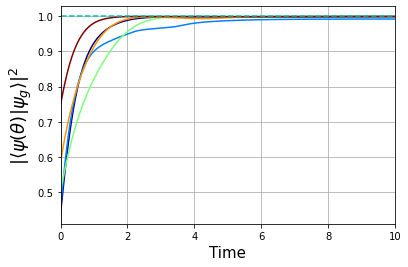

In [241]:
n = 5
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(5):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk])
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.legend()
plt.xlim(0,10)
#plt.ylim(0.99,1)

plt.savefig("Imaginary_time_evolution_fidelity_3qutrits_M=0.1_N=2_comparison.pdf")

No handles with labels found to put in legend.


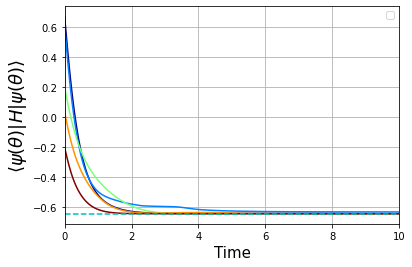

In [245]:
for kkk in range(5):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk])
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_comparison.pdf")

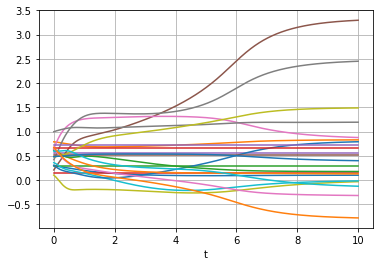

In [238]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

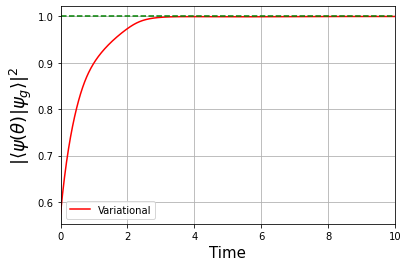

(0.0, 10.0)

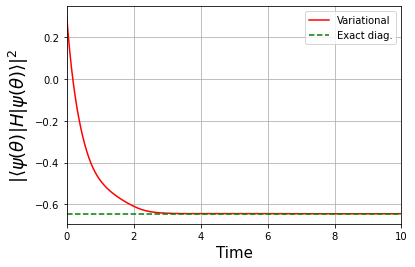

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
